این فایل مدل پیش بینی با الگوریتم catboost میباشد. این مدل یکی از مدل های جدید می‌باشد که بر اساس درخت تصمیم کار میکند و نتایج آن نشان میدهد در مقایسه با مدل sarima پیش بینی بهتری دارد.
نکته قابل ذکر این است که مدت پیش بینی فقط برای داده تست و تا ۱۱ هفته انجام شد(نه ۵۲ هفته یا همان ۱ سال). دلیل این اتفاق نداشتن اطلاعات مربوط به سال اینده مانند اب و هوا و یا سایر اطلاعات سیستم هواپیمایی میباسشد. برای مثال داده های اب و هوایی فقط برای چند روز اینده موجود است.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import jdatetime
from datetime import datetime
import meteostat
from meteostat import Point,Daily
import math

In [2]:
df= pd.read_csv('/home/zahramirzaei/Downloads/SnappTrip_BA_Task.csv')

In [3]:
df.head()

,Created Date,Channel,System Type,Is Cancelled,Flightdate,Origin,Destination,Ticket Airline Code,Orders,Tickets,GMV,Commission,MarkUp,Dump
0,2021-04-30,1,Charter,False,2021-04-30,Shiraz,Tehran,12,3,3,17715000.0,NaN,55045.87156,0.0
1,2021-04-30,1,Charter,False,2021-05-02,Tehran,Asalooye,16,3,3,26010000.0,NaN,0.00000,30000.0
2,2021-04-30,1,Charter,False,2021-05-02,Tehran,Kish Island,7,3,3,12682500.0,NaN,0.00000,31500.0
3,2021-04-30,1,Charter,False,2021-05-03,Kish Island,Shiraz,28,3,3,16170000.0,NaN,0.00000,30000.0
4,2021-04-30,1,System,False,2021-05-01,Shiraz,Tehran,3,3,6,27000000.0,1125900.0,NaN,1026000.0


## web scraping for download holiday

این قطعه کد برای استخراج تعطیلات سالیانه در بازه زمانی مشخص شده، از وبسایت time.ir استفاده می‌کند.

 ابتدا درایور مرورگر Selenium را پیکربندی کرده و سپس به وبسایت مربوطه متصل می‌شود. 
سپس، با استفاده از اطلاعات سال شروع و سال پایان داده شده، تعطیلات مربوط به هر سال را استخراج می‌کند.

در هر سال، برنامه ابتدا فیلد ورودی مربوط به سال را پیدا کرده و سپس سال را وارد می‌کند. سپس روی دکمه‌ای کلیک می‌کند تا تقویم سال مورد نظر را نمایش دهد. سپس تعطیلات را برای هر ماه استخراج می‌کند و در یک دیکشنری ذخیره می‌کند. در آخر، درایور مرورگر را می‌بندد و دیکشنری حاوی تعطیلات را برمی‌گرداند.

با استفاده از این قطعه کد، می‌توانید تعطیلات سالیانه در بازه زمانی مشخص شده را استخراج کنید و در قالب یک دیکشنری با سال و ماه‌ها و روزهای تعطیل، ذخیره کنید.


In [4]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

__month_dict = {
            'فروردین': '1', 'اردیبهشت': '2', 'خرداد': '3',
            'تیر': '4', 'اَمرداد': '5', 'شهریور': '6',
            'مهر': '7', 'آبان': '8', 'آذر': '9', 
            'دی': '10', 'بهمن': '11', 'اسفند': '12'
        }

def __setup_driver():
    return webdriver.Chrome(service=Service(ChromeDriverManager().install()))

def get_holidays(from_year: int, to_year: int):
    driver = __setup_driver()
    driver.get('https://www.time.ir/fa/eventyear-%D8%AA%D9%82%D9%88%DB%8C%D9%85-%D8%B3%D8%A7%D9%84%DB%8C%D8%A7%D9%86%D9%87')
    
    holidays_dict = {}
    for year in range(from_year, to_year+1):
        input_field = driver.find_element(by=By.ID, value="ctl00_cphTop_Sampa_Web_View_EventUI_EventYearCalendar10cphTop_3417_txtYear")
        input_field.clear()
        input_field.send_keys(year)
        driver.find_element(by=By.ID, value="ctl00_cphTop_Sampa_Web_View_EventUI_EventYearCalendar10cphTop_3417_btnGo").click()

        holidays_dict[str(year)] = {}
        current_month = 1
        calender = driver.find_elements(by=By.CLASS_NAME, value="dayList")
        for month in calender:
            holidays = month.find_elements(by=By.CLASS_NAME, value="holiday ")
            for holiday in holidays:
                parent = holiday.find_element(by=By.XPATH, value="..")
                if parent.get_attribute('class') == "spacer disabled":
                    continue
                if str(current_month) not in holidays_dict[str(year)]:
                    holidays_dict[str(year)][str(current_month)] = []

                day = holiday.text.split()[0]
                holidays_dict[str(year)][str(current_month)].append(str(int(day)))
            current_month += 1
    driver.close()
    return holidays_dict

In [5]:
holiday= get_holidays(1400,1402)

در کد زیر داده های اب و هوا مربوط به بازه زمانی مورد نظر گرفته می‌شود.

In [6]:
start = datetime(2021, 4, 30)
end = datetime(2024, 9, 24)

# Create Point for Tehran, Iran
place = Point(35.6892, 51.3890)

data = Daily(place, start, end)
data = data.fetch()

data= data.reset_index()
data['time'] = pd.to_datetime(data['time'])

data= data.reset_index()
data['time'] = pd.to_datetime(data['time'])

df_temp = data.groupby([data['time'].dt.weekofyear.rename('week of year')]).\
agg({'tavg':'mean', 'wspd':'mean'})

## preprocess

در کد زیر ما جیسون دانلود شده تعطیلات را به شکل تازیخ شمسی در آوزده تا بتوانیم با تازیخ جلالی تطبیق دهیم و تعطیلات را به اضای هرروز به صورت یک ستون باینری نشان دهیم.

In [7]:
#change type of datetime column
df['Flightdate'] = pd.to_datetime(df['Flightdate'])

# Convert each datetime value to Persian (Jalali) time so we can apply persian holiday
df['persian_time'] = df['Flightdate'].apply(lambda x: jdatetime.datetime.\
                                              fromgregorian(datetime=x).strftime('%Y-%m-%d'))

# for loop for making Json shape like date
for year in holiday.keys():
    for month in holiday[year].keys():
        for day in holiday[year][month]:
            if int(month) < 10 and int(day) > 9:
                date_str = f'{year}-{"0" + str(month)}-{day}'  # Construct the date string
            elif int(month) < 10 and int(day) <= 9:
                date_str = f'{year}-{"0" + str(month)}-{"0" + str(day)}'  
            elif int(month) > 9 and int(day) < 10:
                date_str = f'{year}-{month}-{"0" + str(day)}'  
            else:
                date_str = f'{year}-{month}-{day}'  
            #creating binary column for holiday
            condition = (df['persian_time'] == date_str)
            df.loc[condition, 'holiday'] = 1
            df['holiday'] = df['holiday'].fillna(0)

علاوه بر تعطیلات، اضافه کردن روزهای اخر هفته میتواند به دقت مدل کمک کند

In [8]:
def applyer(row):
    if row.dayofweek == 4 or row.dayofweek == 5: # day number 4 and 5 are thursday and friday
        
        return 1
    else:
        return 0

In [9]:
df['DayofWeek'] = df['Flightdate'].dt.dayofweek
df['weekend'] = df['Flightdate'].apply(applyer)
df.loc[df['weekend'] == 1, 'holiday'] = 1

آماده سازی دیتافریم اصلی:

تسک پیش بینی، مربوط به پیش بینی ماهیانه برای ۱۲ ماه می‌باشد. در نتیجه تاریخ ها باید به صورت ماهیانه تبدیل گردد.
اما با توجه به تعداد کمک داده ها در صورت گروه کردن براساس ماه و با توجه به ثابت بودن برخی تعطیلات شمسی در هفته های مختلف، داده ها بر اساس هفته گروه بندی گردیدند. 

فیچر ها:

از آنجایی که تسک مربوط به پیش بینی تعداد بلیط و مبلغ می‌باشد و از آنجایی  که مبلغ با تعداد بلیط همبستگی زیادی دارد، و با توجه به نامربوط بودن اکثر فیچرها در فروش تعداد بلیط، فقط از فیجرهای تعدادبلیط- تعطیلات- دامپ و مارک آپ برای مدل استفاده شد. 
یکی از مقادیر مهم تاثیرگذار در پیش بینی، هفته ای میباشد که بلیط در ان خریداری شده است. زیرا در هفته های سال براساس تاریخ شمسی تعطیلات ثابتی مانند عید نوروز، یلدا و  .. وجود دارد. و چون این روند تکرار پذیر است، برای شماره هر هفته سال یک تعبیه سازی به صورت کسینوس عدد پی در عدد هفته تقسیم بر تعداد هفته ها ایجاد گردید.

In [10]:
df_cat = df.groupby([df.Flightdate.dt.weekofyear.rename('week of year')]).\
agg({'Tickets': 'sum','GMV':'sum','holiday':'sum','Dump':'sum','MarkUp':'sum'}).reset_index()
df_cat['week_embed']=df_cat['week of year'].apply(lambda x: math.cos(math.pi * x / 52))

In [11]:
df_cat.head()

,week of year,Tickets,GMV,holiday,Dump,MarkUp,week_embed
0,1,221832,2.002809e+12,11609.0,1.279416e+10,1.047285e+10,0.998176
1,2,216075,1.983783e+12,9340.0,1.555786e+10,1.031859e+10,0.992709
2,3,224361,2.103033e+12,9156.0,1.560317e+10,1.121612e+10,0.983620
3,4,212757,2.100926e+12,8721.0,1.421369e+10,1.232156e+10,0.970942
4,5,208365,2.079780e+12,9035.0,1.570944e+10,1.026295e+10,0.954721


In [12]:
df_temp.head()

,tavg,wspd
week of year,,
1,5.578571,9.392857
2,4.814286,9.671429
3,2.742857,10.642857
4,3.864286,10.500000
5,6.214286,13.578571


دو دیتافریم اب و هوا و داده های اصلی را یکی میکنیم

In [13]:
df_model = pd.merge(df_cat, df_temp, on='week of year')

In [14]:
df_model.head()

,week of year,Tickets,GMV,holiday,Dump,MarkUp,week_embed,tavg,wspd
0,1,221832,2.002809e+12,11609.0,1.279416e+10,1.047285e+10,0.998176,5.578571,9.392857
1,2,216075,1.983783e+12,9340.0,1.555786e+10,1.031859e+10,0.992709,4.814286,9.671429
2,3,224361,2.103033e+12,9156.0,1.560317e+10,1.121612e+10,0.983620,2.742857,10.642857
3,4,212757,2.100926e+12,8721.0,1.421369e+10,1.232156e+10,0.970942,3.864286,10.500000
4,5,208365,2.079780e+12,9035.0,1.570944e+10,1.026295e+10,0.954721,6.214286,13.578571


In [15]:
df_model['GMV']=df_model['GMV'].astype(int)
df_model['holiday']=df_model['holiday'].astype(int)
df_model['Dump']=df_model['Dump'].astype(int)
df_model['MarkUp']=df_model['MarkUp'].astype(int)

In [16]:
# df_model.to_excel('/home/zahramirzaei/Downloads/presnap.xlsx')

## model implementation

In [17]:
import catboost as cb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

این قطعه کد برای تقسیم داده‌ها به دو مجموعه آموزش و آزمون استفاده می‌شود. ابتدا، داده‌های ویژگی (week of year، holiday، Dump و MarkUp) را از ستون‌های مربوطه در دیتافریم df_cat استخراج می‌کند و در متغیر X ذخیره می‌کند. سپس، داده‌های هدف (Tickets) را از ستون مربوطه در df_cat استخراج کرده و در متغیر y ذخیره می‌کند.

سپس با استفاده از تابع train_test_split از کتابخانه sklearn، داده‌ها به دو مجموعه آموزش و آزمون تقسیم می‌شوند. مجموعه آزمون به نسبت 0.2 (یا 20 درصد) از کل داده‌ها تشکیل می‌شود و مجموعه آموزش نیز باقیمانده داده‌ها را شامل می‌شود. علاوه بر این، تقسیم داده‌ها با استفاده از random_state=5 انجام می‌شود تا قابلیت تکرارپذیری داشته باشد.

در نتیجه، متغیرهای X_train و y_train شامل داده‌های آموزش و متغیرهای X_test و y_test شامل داده‌های آزمون خواهند بود. این داده‌ها برای استفاده در الگوریتم‌ها و مدل‌های یادگیری ماشینی به کار می‌روند.

این نکته قابل ذکر است که برای پیاده سازی هر مدلی کارهایی از قبیل نرمال سازی داده ها باید انجام گیرد اما از آنجایی که مدل catboost به اسکیل داده ها حساس نیست و به دلیل کمبود وقت برای انجام تسک، نرمال سازی انجام نشد

In [18]:
X=df_model[['week of year','holiday','Dump', 'MarkUp', 'tavg', 'wspd','week_embed']].values
y=df_model['Tickets'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

در این قطعه کد، داده‌های آموزش و آزمون به فرمتی مناسب برای استفاده در مدل یادگیری گرادیان بوستینگ (CatBoost) تبدیل می‌شوند.

از کلاس Pool در ماژول cb (مخفف CatBoost) استفاده می‌شود. ابتدا، داده‌های ویژگی آموزش (X_train) و داده‌های هدف آموزش (y_train) به عنوان ورودی به کلاس Pool پاس داده می‌شوند و در train_dataset قرار می‌گیرند. این کلاس Pool قابلیت‌هایی را فراهم می‌کند که به مدل CatBoost در زمان آموزش کمک می‌کند.

همچنین، داده‌های ویژگی آزمون (X_test) و داده‌های هدف آزمون (y_test) نیز به کلاس Pool پاس داده می‌شوند و در test_dataset قرار می‌گیرند. این دو کلاس Pool به عنوان ورودی‌هایی برای مدل CatBoost در مراحل آموزش و ارزیابی استفاده می‌شوند.

به این ترتیب، داده‌های آموزش و آزمون به فرمتی قابل قبول برای مدل CatBoost تبدیل شده و برای آموزش و ارزیابی مدل آماده می‌شوند.

In [19]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

در این قطعه کد، هایپرپارامترهای بهینه‌سازی برای مدل CatBoostRegressor با استفاده از روش جستجوی شبکه (Grid Search) تعریف شده‌اند. پارامترهایی که برای بهینه‌سازی در نظر گرفته شده‌اند عبارتند از:

- depth: عمق مجموعه درخت‌های گرادیانی
- learning_rate: نرخ یادگیری مدل
- iterations: تعداد تکرارهای آموزش

مدل CatBoostRegressor با استفاده از تابع خطا RMSE (ریشه میانگین مربعات خطا) تعریف شده است.

سپس یک شیء GridSearchCV ایجاد شده است. این شیء برای جستجوی بهترین پارامترها استفاده می‌شود. تعداد اجراها و تقسیم بندی مدل به دو قسمت آموزش و ارزیابی با استفاده از پارامترهای cv و n_jobs تنظیم می‌شوند.

سپس مدل به داده‌های آموزش (X_train و y_train) برازش می‌شود تا بهترین پارامترها را پیدا کند. پس از اجرای GridSearchCV، بهترین پارامترها و بهترین امتیاز به عنوان best_params و best_score دریافت می‌شوند.

در نهایت، بهترین پارامترها و بهترین امتیاز چاپ می‌شوند.

In [20]:
# Define the parameter grid 
#hyper pharam tuning
parameters = {'depth': [6, 8, 10],
              'learning_rate': [0.01, 0.05, 0.1],
              'iterations': [30, 50, 100]
              }

# Create a CatBoostRegressor model
model = CatBoostRegressor(loss_function='RMSE')

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=parameters, cv=2, n_jobs=-1)

# Fit the model to find the best parameters
grid.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid.best_params_
best_score = grid.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)


0:	learn: 31584.1063061	total: 114ms	remaining: 3.32s
1:	learn: 30722.7228343	total: 115ms	remaining: 1.61s
2:	learn: 29451.0699852	total: 118ms	remaining: 1.06s
3:	learn: 28368.2043874	total: 119ms	remaining: 771ms
4:	learn: 27224.3430881	total: 120ms	remaining: 599ms
5:	learn: 26195.3889297	total: 130ms	remaining: 521ms
6:	learn: 25348.2966820	total: 131ms	remaining: 431ms
7:	learn: 24098.7839276	total: 140ms	remaining: 386ms
8:	learn: 23038.5745994	total: 141ms	remaining: 328ms
9:	learn: 22140.4918335	total: 142ms	remaining: 283ms
10:	learn: 21166.8367415	total: 142ms	remaining: 246ms
11:	learn: 20443.3126701	total: 143ms	remaining: 214ms
12:	learn: 19581.8921691	total: 151ms	remaining: 198ms
13:	learn: 18817.7095659	total: 151ms	remaining: 173ms
14:	learn: 17941.8907817	total: 152ms	remaining: 152ms
15:	learn: 17339.5796864	total: 152ms	remaining: 133ms
16:	learn: 16647.0474994	total: 152ms	remaining: 116ms
17:	learn: 16012.3747519	total: 152ms	remaining: 101ms
18:	learn: 15448.210

0:	learn: 32230.8550299	total: 107ms	remaining: 3.1s
1:	learn: 31790.1367240	total: 109ms	remaining: 1.53s
2:	learn: 31129.2844686	total: 110ms	remaining: 986ms
3:	learn: 30551.5393753	total: 110ms	remaining: 716ms
4:	learn: 29933.3874782	total: 117ms	remaining: 585ms
5:	learn: 29363.4465351	total: 118ms	remaining: 471ms
6:	learn: 28887.7717465	total: 118ms	remaining: 389ms
7:	learn: 28283.1910225	total: 119ms	remaining: 327ms
8:	learn: 27655.6979379	total: 127ms	remaining: 296ms
9:	learn: 27107.5259830	total: 133ms	remaining: 265ms
10:	learn: 26500.8644545	total: 133ms	remaining: 230ms
11:	learn: 26038.4256172	total: 135ms	remaining: 202ms
12:	learn: 25505.3494257	total: 136ms	remaining: 177ms
13:	learn: 24978.3494410	total: 136ms	remaining: 156ms
14:	learn: 24564.5440426	total: 137ms	remaining: 137ms
15:	learn: 24179.3442100	total: 138ms	remaining: 121ms
16:	learn: 23698.3502550	total: 138ms	remaining: 106ms
17:	learn: 23163.7391816	total: 143ms	remaining: 95ms
18:	learn: 22636.77479

9:	learn: 22140.4918335	total: 51.6ms	remaining: 464ms
10:	learn: 21166.8367415	total: 52.4ms	remaining: 424ms
11:	learn: 20443.3126701	total: 53.1ms	remaining: 390ms
12:	learn: 19581.8921691	total: 64.3ms	remaining: 430ms
13:	learn: 18817.7095659	total: 65ms	remaining: 399ms
14:	learn: 17941.8907817	total: 70.4ms	remaining: 399ms
15:	learn: 17339.5796864	total: 72.6ms	remaining: 381ms
16:	learn: 16647.0474994	total: 74.3ms	remaining: 363ms
17:	learn: 16012.3747519	total: 74.8ms	remaining: 341ms
18:	learn: 15448.2105638	total: 78.6ms	remaining: 335ms
19:	learn: 14972.2820595	total: 79ms	remaining: 316ms
20:	learn: 14491.6951713	total: 79.3ms	remaining: 298ms
21:	learn: 13955.5251414	total: 79.7ms	remaining: 283ms
22:	learn: 13367.5966858	total: 83.2ms	remaining: 279ms
23:	learn: 12924.9908728	total: 83.6ms	remaining: 265ms
24:	learn: 12356.4681635	total: 87.1ms	remaining: 261ms
25:	learn: 11899.2953847	total: 87.4ms	remaining: 249ms
26:	learn: 11555.1879380	total: 87.7ms	remaining: 237

33:	learn: 13260.5907796	total: 13.8ms	remaining: 26.8ms
34:	learn: 13027.2146150	total: 14.4ms	remaining: 26.7ms
35:	learn: 12789.6804350	total: 15.1ms	remaining: 26.9ms
36:	learn: 12571.5536523	total: 15.4ms	remaining: 26.3ms
37:	learn: 12377.9470335	total: 16.1ms	remaining: 26.3ms
38:	learn: 12205.6311220	total: 16.9ms	remaining: 26.5ms
39:	learn: 11973.2801166	total: 17.4ms	remaining: 26.1ms
40:	learn: 11771.5418636	total: 18.1ms	remaining: 26.1ms
41:	learn: 11583.4158581	total: 18.8ms	remaining: 25.9ms
42:	learn: 11318.0094180	total: 18.9ms	remaining: 25.1ms
43:	learn: 11171.1382446	total: 20.1ms	remaining: 25.6ms
44:	learn: 10972.5159156	total: 20.6ms	remaining: 25.1ms
45:	learn: 10802.3433458	total: 20.8ms	remaining: 24.4ms
46:	learn: 10660.4286385	total: 21.6ms	remaining: 24.4ms
47:	learn: 10514.1597034	total: 22.3ms	remaining: 24.2ms
48:	learn: 10316.3744764	total: 22.9ms	remaining: 23.8ms
49:	learn: 10109.9739223	total: 23.1ms	remaining: 23.1ms
50:	learn: 9963.6542526	total: 

33:	learn: 7435.8544250	total: 13ms	remaining: 25.2ms
34:	learn: 7202.6879563	total: 30.3ms	remaining: 56.3ms
35:	learn: 7008.9551986	total: 48.9ms	remaining: 87ms
36:	learn: 6740.3277989	total: 51.3ms	remaining: 87.3ms
37:	learn: 6517.2195104	total: 52.2ms	remaining: 85.2ms
38:	learn: 6313.1752966	total: 52.8ms	remaining: 82.6ms
39:	learn: 6105.4336866	total: 62.6ms	remaining: 93.8ms
40:	learn: 5943.1980239	total: 67.3ms	remaining: 96.8ms
41:	learn: 5779.7787026	total: 67.9ms	remaining: 93.7ms
42:	learn: 5618.3268812	total: 68.7ms	remaining: 91.1ms
43:	learn: 5462.5311152	total: 69.4ms	remaining: 88.4ms
44:	learn: 5303.0220181	total: 69.7ms	remaining: 85.2ms
45:	learn: 5160.2858956	total: 70.9ms	remaining: 83.3ms
46:	learn: 5025.8956352	total: 71.2ms	remaining: 80.3ms
47:	learn: 4872.4727150	total: 71.8ms	remaining: 77.8ms
48:	learn: 4740.6373592	total: 73ms	remaining: 76ms
49:	learn: 4616.0569699	total: 73.8ms	remaining: 73.8ms
50:	learn: 4497.6485414	total: 74.7ms	remaining: 71.7ms


Best parameters: {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}
Best score: 0.8086191182872766


In [21]:
# Define the best parameters obtained from grid search
best_params = {'depth': 6, 'learning_rate': 0.1, 'iterations': 100}

# Create a CatBoostRegressor model with the best parameters
model = CatBoostRegressor(**best_params)

# Train the model with your training data
model.fit(X_train, y_train)

0:	learn: 27463.3360324	total: 870us	remaining: 86.2ms
1:	learn: 26104.6286284	total: 2.14ms	remaining: 105ms
2:	learn: 24690.3968331	total: 2.73ms	remaining: 88.4ms
3:	learn: 23554.8172485	total: 3.34ms	remaining: 80.2ms
4:	learn: 22441.5356906	total: 3.92ms	remaining: 74.6ms
5:	learn: 21318.1124170	total: 4.29ms	remaining: 67.2ms
6:	learn: 20153.9367790	total: 4.74ms	remaining: 63ms
7:	learn: 19198.2241447	total: 5.32ms	remaining: 61.1ms
8:	learn: 18271.9343440	total: 5.94ms	remaining: 60ms
9:	learn: 17402.4861805	total: 6.54ms	remaining: 58.8ms
10:	learn: 16789.3862820	total: 7.12ms	remaining: 57.6ms
11:	learn: 15987.2369522	total: 7.77ms	remaining: 57ms
12:	learn: 15252.9253161	total: 8.36ms	remaining: 56ms
13:	learn: 14497.3250621	total: 8.93ms	remaining: 54.9ms
14:	learn: 14006.4673086	total: 9.55ms	remaining: 54.1ms
15:	learn: 13516.2444154	total: 10.3ms	remaining: 54.1ms
16:	learn: 12952.5949899	total: 10.9ms	remaining: 53.4ms
17:	learn: 12386.1938292	total: 11.5ms	remaining: 5

در این قطعه کد، پارامترهای بهترین به دست آمده از جستجوی شبکه (grid search) تعریف شده‌اند و در متغیر best_params قرار می‌گیرند. این پارامترها شامل {'depth': 6, 'learning_rate': 0.1, 'iterations': 50} هستند.

سپس یک مدل CatBoostRegressor با استفاده از بهترین پارامترها ایجاد می‌شود. از عملگر ** برای انتقال پارامترها به عنوان آرگومان‌های کلیدی استفاده می‌شود.

سپس مدل با استفاده از داده‌های آموزش (X_train و y_train) آموزش داده می‌شود. سپس پیش‌بینی‌ها بر روی داده‌های آزمون (X_test) انجام می‌شود و در متغیر predictions قرار می‌گیرند.

بعد از انجام پیش‌بینی‌ها، عملکرد مدل روی داده‌های آزمون محاسبه می‌شود. ابتدا معیار RMSE (ریشه میانگین مربعات خطا) با استفاده از توابع np.sqrt و mean_squared_error محاسبه می‌شود و در متغیر rmse قرار می‌گیرد. همچنین، معیار R2 نیز با استفاده از تابع r2_score محاسبه می‌شود و در متغیر r2 قرار می‌گیرد.

R-squared (R2) و Root Mean Square Error (RMSE) هر دو معیارهایی هستند که معمولاً برای ارزیابی عملکرد مدل استفاده می‌شوند.     R-squared یک معیار آماری است که نشان دهنده نسبت واریانس در متغیر وابسته (متغیر هدف) است که می تواند توسط متغیرهای مستقل (ویژگی ها) در یک مدل رگرسیونی توضیح داده شود. این نشان می دهد که مدل چقدر با داده ها مطابقت دارد. مقدار R2 از 0 تا 1 متغیر است که 0 نشان می دهد که مدل هیچ یک از واریانس های متغیر هدف را توضیح نمی دهد و 1 نشان می دهد که مدل تمام واریانس ها را توضیح می دهد. با این حال، اگر مدل بدتر از یک خط افقی ساده عمل کند، مقادیر R2 منفی نیز ممکن است رخ دهد.
     RMSE اندازه گیری میانگین خطای پیش بینی یک مدل رگرسیونی است. این نشان دهنده جذر میانگین اختلاف مجذور بین مقادیر پیش بینی شده و واقعی است. RMSE معمولاً برای تعیین کمیت مقدار کلی باقیمانده ها (خطاهای پیش بینی) در مدل استفاده می شود. مقادیر پایین تر RMSE نشان دهنده عملکرد بهتر مدل است که 0 مقدار ایده آل است


In [24]:
# Make predictions on your test data
predictions = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, predictions)))
r2 = r2_score(y_test, predictions)
print("Testing performance")
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 9347.10
R2: 0.93


نتایج نشان میدهد مدل ما دقت نسبتا خوبی برای پیش بینی دارد و از مدل ساریما خیلی بهتر عمل می‌کند

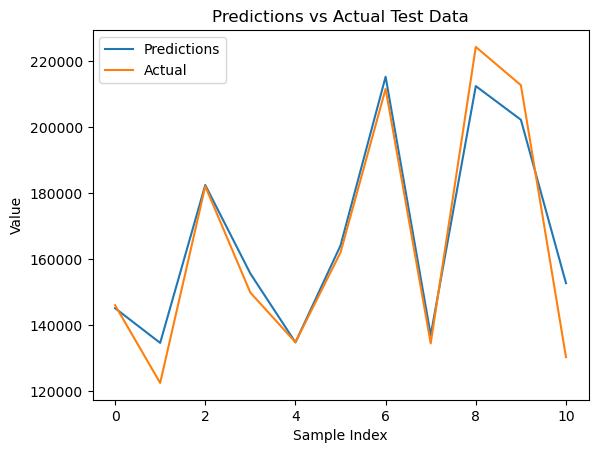

In [25]:
import matplotlib.pyplot as plt

# Assuming you have the predictions stored in 'predictions' and the test data in 'y_test'

# Plot the predicted values
plt.plot(predictions, label='Predictions')

# Plot the actual test data
plt.plot(y_test, label='Actual')

plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Predictions vs Actual Test Data')
plt.legend()
plt.show()

در انتها میتوان تاثیر فیچرهای مختلف را بر روی مدل پیش بینی سنجید 
برای مثال این نمودار نشان میدهد فیچر ۴ ام ما تاثیر زیادی روی مدل داشته است

In [26]:
import shap

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


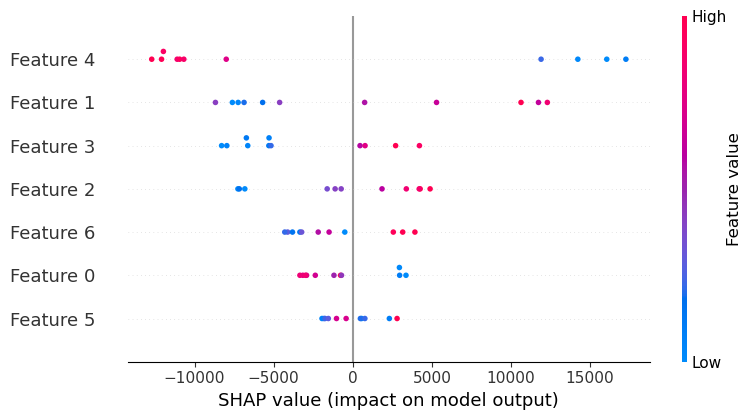

In [27]:
explainer = shap.Explainer(model)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test)

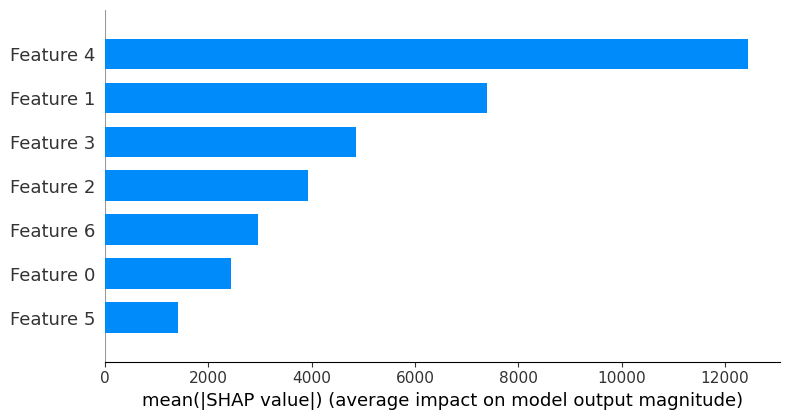

In [28]:
shap.summary_plot(shap_values, X_train, plot_type="bar")